# Extensions to Linear Models - Lab

## Introduction

In this lab, you'll practice many concepts you have learned so far, from adding interactions and polynomials to your model to regularization!

## Summary

You will be able to:

- Build a linear regression model with interactions and polynomial features 
- Use feature selection to obtain the optimal subset of features in a dataset

## Let's Get Started!

Below we import all the necessary packages for this lab.

In [31]:
# Run this cell without changes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from itertools import combinations

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import RepeatedKFold

Load the data.

In [19]:
# Run this cell without changes

# Load data from CSV
df = pd.read_csv("ames.csv")
# Subset columns
df = df[['LotArea', 'OverallQual', 'OverallCond', 'TotalBsmtSF',
         '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'TotRmsAbvGrd',
         'GarageArea', 'Fireplaces', 'SalePrice']]

# Split the data into X and y
y = df['SalePrice']
X = df.drop(columns='SalePrice')

# Split into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0)

## Build a Baseline Housing Data Model

Above, we imported the Ames housing data and grabbed a subset of the data to use in this analysis.

Next steps:

- Scale all the predictors using `StandardScaler`, then convert these scaled features back into DataFrame objects
- Build a baseline `LinearRegression` model using *scaled variables* as predictors and use the $R^2$ score to evaluate the model 

In [20]:
# Your code here
# Scale X_train and X_val using StandardScaler
scaler = StandardScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train)
X_val[X_val.columns] = scaler.transform(X_val)

assert type(X_train) == pd.DataFrame
assert type(X_val) == pd.DataFrame
X_train.shape

(821, 10)

In [21]:
# Your code here
# Create a LinearRegression model and fit it on scaled training data
linreg = LinearRegression().fit(X_train, y_train)

# Calculate a baseline r-squared score on training data
linreg.score(X_train, y_train)


0.7868344817421309

## Add Interactions

Instead of adding all possible interaction terms, let's try a custom technique. We are only going to add the interaction terms that increase the $R^2$ score as much as possible. Specifically we are going to look for the 7 interaction terms that each cause the most increase in the coefficient of determination.

### Find the Best Interactions

Look at all the possible combinations of variables for interactions by adding interactions one by one to the baseline model. Create a data structure that stores the pair of columns used as well as the $R^2$ score for each combination.

***Hint:*** We have imported the `combinations` function from `itertools` for you ([documentation here](https://docs.python.org/3/library/itertools.html#itertools.combinations)). Try applying this to the columns of `X_train` to find all of the possible pairs.

Print the 7 interactions that result in the highest $R^2$ scores.

In [22]:
# Generate all possible pairs of columns
combos = list(combinations(X_train.columns, 2))
r2_scores = []

# Find combinations of columns and loop over them
for combo in combos:
    # Make copies of X_train and X_val
    x_train_copy = X_train.copy()
    x_val_copy = X_val.copy()
    
    # Add interaction term to data
    interaction_term_name = f"{combo[0]}_{combo[1]}"
    x_train_copy[interaction_term_name] = x_train_copy[combo[0]] * x_train_copy[combo[1]]
    x_val_copy[interaction_term_name] = x_val_copy[combo[0]] * x_val_copy[combo[1]]
    
    # Fit the model on training data and evaluate on validation data
    linreg = LinearRegression().fit(x_train_copy, y_train)
    r2_score_val = linreg.score(x_val_copy, y_val)
    
    # Store the combination and its corresponding R^2 score
    r2_scores.append((combo, r2_score_val))

# Sort the results by R^2 score in descending order
r2_scores.sort(key=lambda x: x[1], reverse=True)

# Extract the top 7 interactions
top_7_interactions = r2_scores[:7]

# Print the top 7 interactions and their R^2 scores
print("Top 7 Interaction Terms:")
for interaction, r2 in top_7_interactions:
    print(f"Interaction: {interaction}, R^2: {r2}")

Top 7 Interaction Terms:
Interaction: ('LotArea', '1stFlrSF'), R^2: 0.7211105666140571
Interaction: ('LotArea', 'TotalBsmtSF'), R^2: 0.707164920705011
Interaction: ('LotArea', 'GrLivArea'), R^2: 0.6690980823779022
Interaction: ('LotArea', 'Fireplaces'), R^2: 0.6529699515652586
Interaction: ('2ndFlrSF', 'TotRmsAbvGrd'), R^2: 0.647299489040519
Interaction: ('OverallCond', 'TotalBsmtSF'), R^2: 0.642901987923377
Interaction: ('OverallQual', '2ndFlrSF'), R^2: 0.6422324294284367


### Add the Best Interactions

Write code to include the 7 most important interactions in `X_train` and `X_val` by adding 7 columns. Use the naming convention `"col1_col2"`, where `col1` and `col2` are the two columns in the interaction.

In [23]:
# Your code here

# Loop over top 7 interactions
for interaction, r2 in top_7_interactions:
    # Add new column to X_train and X_val
    X_train[f"{interaction[0]}_{interaction[1]}"] = X_train[interaction[0]] * X_train[interaction[1]]
    X_val[f"{interaction[0]}_{interaction[1]}"] = X_val[interaction[0]] * X_val[interaction[1]]


## Add Polynomials

Now let's repeat that process for adding polynomial terms.

### Find the Best Polynomials

Try polynomials of degrees 2, 3, and 4 for each variable, in a similar way you did for interactions (by looking at your baseline model and seeing how $R^2$ increases). Do understand that when going for a polynomial of degree 4 with `PolynomialFeatures`, the particular column is raised to the power of 2 and 3 as well in other terms.

We only want to include "pure" polynomials, so make sure no interactions are included.

Once again you should make a data structure that contains the values you have tested. We recommend a list of tuples of the form:

`(col_name, degree, R2)`, so eg. `('OverallQual', 2, 0.781)` 

In [24]:
# Your code here

# Set up data structure
r2_scores = []
# Loop over all columns
for column in X_train.columns:
    # Loop over degrees 2, 3, 4
    for degree in [2, 3, 4]:    
        # Make a copy of X_train and X_val
        x_train_copy = X_train.copy()
        x_val_copy = X_val.copy()
        # Instantiate PolynomialFeatures with relevant degree
        poly = PolynomialFeatures(degree)
        x_train_copy[column] = poly.fit_transform(x_train_copy[[column]])
        x_val_copy[column] = poly.transform(x_val_copy[[column]])
        # Fit polynomial to column and transform column
        # Hint: use the notation df[[column_name]] to get the right shape
        # Hint: convert the result to a DataFrame
        # Add polynomial to data
        # Hint: use pd.concat since you're combining two DataFrames
        # Hint: drop the column before combining so it doesn't appear twice
        linreg = LinearRegression().fit(x_train_copy, y_train)
        r2_scores.append((column, degree, linreg.score(x_val_copy, y_val)))
    
        # Find r-squared score on validation
    
        # Append to data structure

# Sort and subset the data structure to find the top 7
r2_scores.sort(key=lambda x: x[2], reverse=True)
top_7_columns = r2_scores[:7]

### Add the Best Polynomials

If there are duplicate column values in the results above, don't add multiple of them to the model, to avoid creating duplicate columns. (For example, if column `A` appeared in your list as both a 2nd and 3rd degree polynomial, adding both would result in `A` squared being added to the features twice.) Just add in the polynomial that results in the highest R-Squared.

In [25]:
# Your code here

# Filter out duplicates
top_7_columns = pd.DataFrame(top_7_columns).drop_duplicates(subset=[0]).values
polynomial_df = pd.DataFrame()
polynomial_df_val = pd.DataFrame()

# Loop over remaining results
for column, degree, r2 in top_7_columns:
    # Create polynomial terms
    poly = PolynomialFeatures(degree)
    
    poly_train = poly.fit_transform(X_train[[column]])
    cols = [column+str(i+1) for i in range(degree + 1)]
    polynomial_df_item = pd.DataFrame(poly_train)
    polynomial_df_item.columns = cols
    
    poly_val = poly.transform(X_val[[column]])
    polynomial_df_val_item = pd.DataFrame(poly_val)
    polynomial_df_val_item.columns = cols  

    # Concat new polynomials to X_train and X_val
    polynomial_df = pd.concat([polynomial_df, polynomial_df_item], axis=1)
    polynomial_df_val = pd.concat([polynomial_df_val, polynomial_df_val_item], axis=1)
    print(polynomial_df.shape, polynomial_df_val.shape)
    

(821, 3) (274, 3)
(821, 6) (274, 6)
(821, 9) (274, 9)


Check out your final data set and make sure that your interaction terms as well as your polynomial terms are included.

In [26]:
# Your code here
X_train = pd.concat([X_train.reset_index(), polynomial_df], axis=1).iloc[:, 1:]
X_val = pd.concat([X_val.reset_index(), polynomial_df_val], axis=1).iloc[:, 1:]

## Full Model R-Squared

Check out the $R^2$ of the full model with your interaction and polynomial terms added. Print this value for both the train and validation data.

In [27]:
# Your code here
linreg = LinearRegression().fit(X_train, y_train)
print(f"training score: {linreg.score(X_train, y_train)}")
print(f"validation score: {linreg.score(X_val, y_val)}")

training score: 0.8086458669828204
validation score: 0.624154517464438


It looks like we may be overfitting some now. Let's try some feature selection techniques.

## Feature Selection

First, test out `RFE` ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html)) with several different `n_features_to_select` values. For each value, print out the train and validation $R^2$ score and how many features remain.

In [28]:
# Your code here
train_scores, test_scores = [], []
for i in range(1, len(X_train.columns)):
    linreg = LinearRegression()
    rfe = RFE(linreg, n_features_to_select=i).fit(X_train, y_train)
    train_scores.append(rfe.score(X_train, y_train))
    test_scores.append(rfe.score(X_val, y_val))


Now test out `Lasso` ([documentation here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)) with several different `alpha` values.

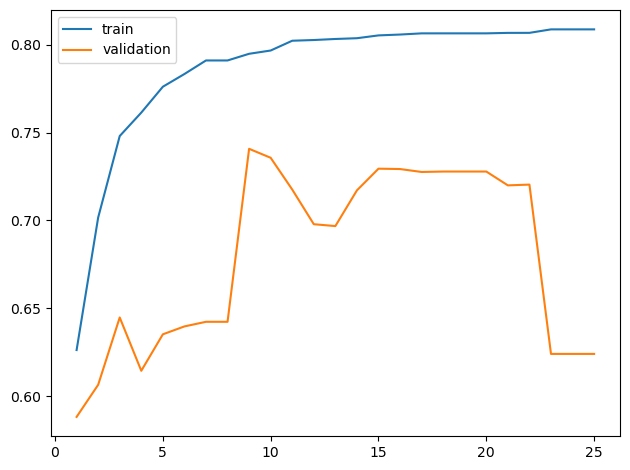

In [29]:
plt.plot(range(1, len(X_train.columns)), train_scores, label="train")
plt.plot(range(1, len(X_train.columns)), test_scores, label="validation")
plt.legend()
plt.tight_layout()


In [32]:
# Your code here
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model = LassoCV(alphas=np.arange(0, 1, 0.01), cv=cv, n_jobs=-1)
model.fit(X_train, y_train)
model.alpha_

0.9400000000000001

Compare the results. Which features would you choose to use?

In [ ]:
# Your written answer here

## Evaluate Final Model on Test Data

### Data Preparation

At the start of this lab, we created `X_test` and `y_test`. Prepare `X_test` the same way that `X_train` and `X_val` have been prepared. This includes scaling, adding interactions, and adding polynomial terms.

In [34]:
# Your code here

### Evaluation

Using either `RFE` or `Lasso`, fit a model on the complete train + validation set, then find R-Squared and MSE values for the test set.

In [ ]:
# Your code here
lasso = Lasso()
lasso.fit(X_train, y_train)
lasso.score(X_val, y_val)

## Level Up Ideas (Optional)

### Create a Lasso Path

From this section, you know that when using `Lasso`, more parameters shrink to zero as your regularization parameter goes up. In scikit-learn there is a function `lasso_path()` which visualizes the shrinkage of the coefficients while $alpha$ changes. Try this out yourself!

https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py

### AIC and BIC for Subset Selection

This notebook shows how you can use AIC and BIC purely for feature selection. Try this code out on our Ames housing data!

https://xavierbourretsicotte.github.io/subset_selection.html

## Summary

Congratulations! You now know how to apply concepts of bias-variance tradeoff using extensions to linear models and feature selection.